# EfficientNet Image Classification
This notebook trains and tests versions 1 & 2 of the EfficientNet model.

## 1. Mount Google Drive (Colab Only)
This section connects to Google Drive to access the dataset.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = '/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment'

%cd "/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment"

import os
assert os.path.exists(DATASET_PATH), "[!] Dataset path does not exist. Please check the path."

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/12m4fX9cAr1HVdx1AB1mgPF26R9bqG4mk/50.021 Artificial Intelligence Group Assignment


## 2. Install Dependencies (Colab Only)
Installs necessary libraries for training and evaluation.

In [ ]:
%%capture
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_running_in_colab():
  %pip install lightning polars
  %pip install icecream rich tqdm

## 3. Import Libraries
Imports all required packages including PyTorch, Lightning, and data processing tools.

In [ ]:
import torch
import torch.nn as nn
import polars as pl
import numpy as np
import lightning as L
from pathlib import Path
from torchmetrics import ConfusionMatrix
from lightning.pytorch.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.transforms import v2
import cv2
from torchmetrics import (
    Accuracy,
    F1Score,
    AUROC,
    ConfusionMatrix
)

## 4. Check GPU Availability
Ensures that a GPU is available for faster training.

In [ ]:
print("GPU available:", torch.cuda.is_available())

GPU available: True


## 5. Define Dataset Class
Creates a PyTorch dataset class for loading and processing images.

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pl.DataFrame, training=False):
        super().__init__()
        paths = dataframe['image_path'].to_numpy().squeeze()
        self.image_path = np.array([
            str(Path('preprocessed_garbage_classification_images') / Path(p).name)
            for p in paths
        ])
        self.garbage_type = dataframe.select('label').to_numpy().squeeze()
        self.garbage_to_idx = {garbage: i for i, garbage in enumerate(np.unique(self.garbage_type))}
        self.training = training

        self.train_transforms = v2.Compose([
            v2.RandomHorizontalFlip(),
            v2.RandomVerticalFlip(),
            v2.RandomErasing(),
        ])

        self.transforms = v2.Compose([
            v2.ToDtype(torch.float32, scale=True),
        ])

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_path = self.image_path[idx]

        try:
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            image = torch.from_numpy(image).float()

            if image.dim() == 2:
                image = image.unsqueeze(0)

            if self.training:
                image = self.train_transforms(image)

            image = self.transforms(image)

            garbage = self.garbage_to_idx[self.garbage_type[idx]]

            return image, torch.tensor(garbage, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise

## Method 1: Modifying first convolution layer

In [ ]:
class EfficientNetModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Load EfficientNetV2-S with pre-trained weights
        self.model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

        # Modify the first convolution layer to accept 1-channel input
        original_conv = self.model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )

        # Copy pre-trained weights (taking only the first channel)
        with torch.no_grad():
            new_conv.weight.data = original_conv.weight.data[:, :1, :, :]

        self.model.features[0][0] = new_conv

        # Modify the classifier layer for the number of classes
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, n_classes)

    def forward(self, x):
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return self.model(x)

class GarbageClassificationData(L.LightningDataModule):
    def __init__(self, ws_root: Path = Path("."), num_workers=0):
        super().__init__()
        metadata_path = ws_root / 'preprocessed_garbage_classification_images' / 'metadata'
        self.train_ds = ImageDataset(pl.read_csv(metadata_path / 'train.csv'), training=True)
        self.val_ds = ImageDataset(pl.read_csv(metadata_path / 'validation.csv'))
        self.test_ds = ImageDataset(pl.read_csv(metadata_path / 'test.csv'))

        self.n_classes = len(self.train_ds.garbage_to_idx)
        self.idx_to_garbage = {v: k for k, v in self.train_ds.garbage_to_idx.items()}

        self.dataloader_extras = dict(
            num_workers=num_workers,
            pin_memory=True,
            persistent_workers=num_workers > 0
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_ds, batch_size=32, shuffle=True, **self.dataloader_extras)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_ds, batch_size=64, **self.dataloader_extras)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_ds, batch_size=64, **self.dataloader_extras)

class LitEfficientNetV2(L.LightningModule):
    def __init__(self, n_classes):
        super().__init__()
        self.model = EfficientNetModel(n_classes)
        self.n_classes = n_classes

        # Initialize metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_f1 = F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=n_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=n_classes)

        # Store metrics for final reporting
        self.test_outputs = []

        # Save hyperparameters
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        loss = torch.nn.functional.cross_entropy(y_pred, y)

        # Log training loss
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        loss = torch.nn.functional.cross_entropy(y_pred, y)

        # Calculate accuracy
        accuracy = (y_pred.argmax(dim=1) == y).float().mean()

        # Log validation metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', accuracy, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)

        # Softmax probabilities for AUROC
        y_pred_proba = torch.nn.functional.softmax(y_pred, dim=1)

        # Compute metrics
        self.test_accuracy(y_pred.argmax(dim=1), y)
        self.test_f1(y_pred.argmax(dim=1), y)
        self.test_auroc(y_pred_proba, y)
        self.test_confusion_matrix(y_pred.argmax(dim=1), y)

        # Store outputs for potential later analysis
        self.test_outputs.append({
            'y_pred': y_pred,
            'y_true': y
        })

        return y_pred

    def on_test_epoch_end(self):
        # Compute and log final metrics
        accuracy = self.test_accuracy.compute()
        f1_score = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()

        # Print detailed metrics
        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Macro F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        # Visualize Confusion Matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        # Optional: Log metrics to TensorBoard if needed
        self.log('test_accuracy', accuracy)
        self.log('test_f1_score', f1_score)
        self.log('test_auroc', auroc)

        # Reset metrics
        self.test_accuracy.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
# Rest of the code remains the same as in the previous example
# Set up checkpoint directory
checkpoint_dir = Path('checkpoints/efficientnetv2')
print(checkpoint_dir.resolve())  # Print absolute path

# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=str(checkpoint_dir),
    filename='garbage-classification-{epoch:02d}-{val_accuracy:.2f}',
    save_top_k=3,
    monitor='val_accuracy',
    mode='max'
)

# Prepare data
garbage_classification_data = GarbageClassificationData(num_workers=4)

# Check for existing checkpoints
checkpoints = list(checkpoint_dir.glob('*.ckpt'))

# Set up trainer with TensorBoard logger
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(save_dir='logs', name='efficientnetv2')

trainer = L.Trainer(
    max_epochs=10,
    accelerator='gpu',
    callbacks=[checkpoint_callback],
    logger=logger
)

# Load from latest checkpoint or start fresh
if checkpoints:
    latest_checkpoint = max(checkpoints, key=lambda x: x.stat().st_mtime)
    print(f"Resuming from checkpoint: {latest_checkpoint}")
    lit_model = LitEfficientNetV2.load_from_checkpoint(
        str(latest_checkpoint),
        n_classes=garbage_classification_data.n_classes
    )
else:
    print("Starting fresh training...")
    lit_model = LitEfficientNetV2(garbage_classification_data.n_classes)

# Start training
trainer.fit(model=lit_model, datamodule=garbage_classification_data)

/content/drive/.shortcut-targets-by-id/12m4fX9cAr1HVdx1AB1mgPF26R9bqG4mk/50.021 Artificial Intelligence Group Assignment/checkpoints/efficientnetv2


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Starting fresh training...


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 131MB/s]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                  | Type                      | Params | Mode 
----------------------------------------------------------------------------
0 | model                 | EfficientNetModel         | 20.2 M | train
1 | test_accuracy         | MulticlassAccuracy        | 0      | train
2 | test_f1               | MulticlassF1Score         | 0      | train
3 | test_auroc            | MulticlassAUROC           | 0      | train
4 | test_confusion_matrix | MulticlassConfusionMatrix | 0      | train
----------------------------------------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total param

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### Method 1 Results

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)



--- Test Metrics ---
Accuracy: 0.7110
Macro F1 Score: 0.7066
AUROC: 0.9530


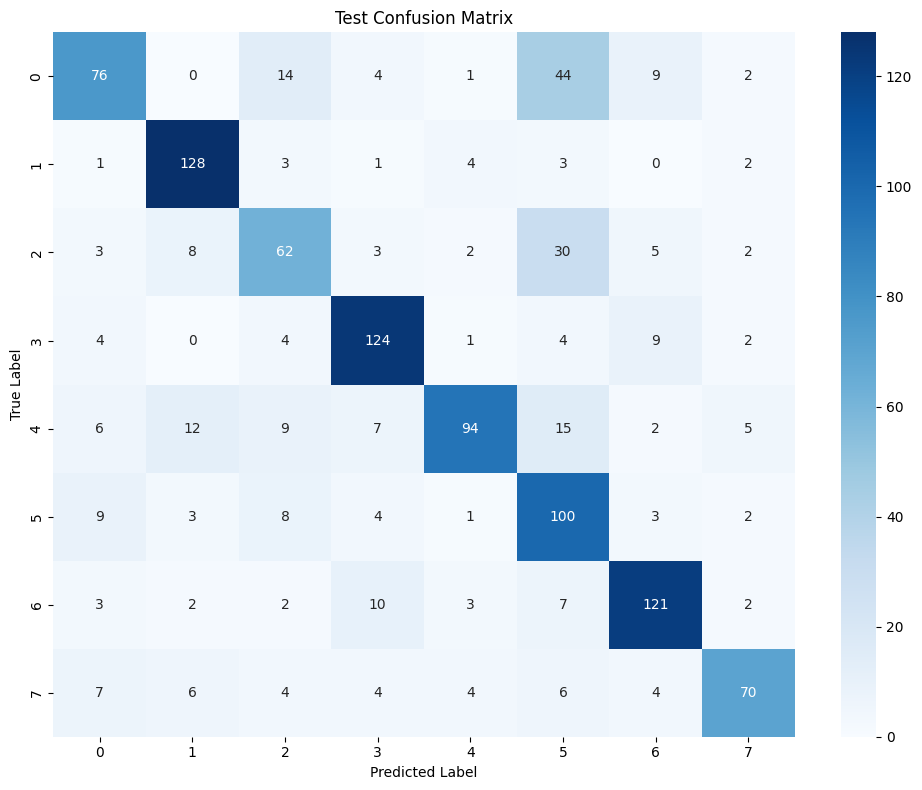

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.71100914478302      │
│        test_auroc         │    0.9530471563339233     │
│       test_f1_score       │    0.7065582275390625     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.71100914478302,
  'test_f1_score': 0.7065582275390625,
  'test_auroc': 0.9530471563339233}]

In [ ]:
trainer.test(model=lit_model, datamodule=garbage_classification_data)

## Method 2: Fine Tuning
Key changes:
- Freezing of 5 early layers to preserve feature extractors, only updating task-specific layers.
- Use a more sophisticated classifier head - 512, ReLU activation
- Regularization: use 0.3 dropout to reduce overfitting

In [ ]:
class GarbageClassificationData(L.LightningDataModule):
    def __init__(self, ws_root: Path = Path("."), num_workers=0):
        super().__init__()
        metadata_path = ws_root / 'preprocessed_garbage_classification_images' / 'metadata'
        self.train_ds = ImageDataset(pl.read_csv(metadata_path / 'train.csv'), training=True)
        self.val_ds = ImageDataset(pl.read_csv(metadata_path / 'validation.csv'))
        self.test_ds = ImageDataset(pl.read_csv(metadata_path / 'test.csv'))

        self.n_classes = len(self.train_ds.garbage_to_idx)
        self.idx_to_garbage = {v: k for k, v in self.train_ds.garbage_to_idx.items()}

        self.dataloader_extras = dict(
            num_workers=num_workers,
            pin_memory=True,
            persistent_workers=num_workers > 0
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_ds, batch_size=32, shuffle=True, **self.dataloader_extras)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_ds, batch_size=64, **self.dataloader_extras)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_ds, batch_size=64, **self.dataloader_extras)

In [ ]:
class EfficientNetV2FineTuned(L.LightningModule):
    """
    A PyTorch Lightning model that fine-tunes EfficientNetV2-S for custom image classification.

    Key Features:
    - Freezes the early layers to retain pre-trained features.
    - Replaces the classifier head with a custom MLP.
    - Uses transfer learning for improved generalization.

    Attributes:
        model (torchvision.models.EfficientNet): Pre-trained EfficientNetV2-S model.
        num_classes (int): Number of output classes.
    """

    def __init__(self, num_classes: int):
        """
        Initializes the fine-tuned EfficientNetV2-S model.

        Args:
            num_classes (int): Number of classes in the dataset.
        """
        super(EfficientNetV2FineTuned, self).__init__()

        # Load pre-trained EfficientNetV2-S model
        self.model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

        # Freeze early layers (first 5 blocks of EfficientNet)
        for param in self.model.features[:5].parameters():
            param.requires_grad = False  # Stop gradients in early layers

        # Modify the first convolutional layer to accept grayscale input (1 channel)
        self.model.features[0][0] = nn.Conv2d(
            in_channels=1,  # Grayscale input
            out_channels=self.model.features[0][0].out_channels,
            kernel_size=self.model.features[0][0].kernel_size,
            stride=self.model.features[0][0].stride,
            padding=self.model.features[0][0].padding,
            bias=False,
        )

        # Modify the classifier head (fully connected layers)
        in_features = self.model.classifier[1].in_features  # Get input size of the classifier
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),  # Add an intermediate hidden layer
            nn.ReLU(),  # Activation function
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(512, num_classes)  # Final output layer
        )

        # Loss function (CrossEntropyLoss for classification)
        self.criterion = nn.CrossEntropyLoss()

        # Initialize metrics for testing
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=num_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)

        # Save number of classes for later use
        self.num_classes = num_classes

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 224, 224).

        Returns:
            torch.Tensor: Model output logits.
        """
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """
        Training step: Computes loss for a batch.

        Args:
            batch (tuple): (images, labels).
            batch_idx (int): Batch index.

        Returns:
            torch.Tensor: Training loss.
        """
        x, y = batch
        y_pred = self.forward(x)
        loss = self.criterion(y_pred, y)

        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step for monitoring model performance during training.

        Args:
            batch (tuple): (images, labels).
            batch_idx (int): Batch index.

        Returns:
            dict: Dictionary containing validation loss and accuracy.
        """
        x, y = batch
        y_pred = self.forward(x)
        loss = self.criterion(y_pred, y)

        # Calculate accuracy
        preds = torch.argmax(y_pred, dim=1)
        acc = (preds == y).float().mean()

        # Log metrics
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', acc, prog_bar=True)

        return {'val_loss': loss, 'val_accuracy': acc}

    def test_step(self, batch, batch_idx):
        """
        Test step for evaluating model on the test dataset.

        Args:
            batch (tuple): (images, labels).
            batch_idx (int): Batch index.

        Returns:
            dict: Dictionary containing test metrics.
        """
        x, y = batch
        y_pred = self.forward(x)
        loss = self.criterion(y_pred, y)

        # Calculate predictions
        preds = torch.argmax(y_pred, dim=1)

        # Update metrics
        self.test_accuracy(preds, y)
        self.test_f1(preds, y)
        self.test_auroc(torch.softmax(y_pred, dim=1), y)
        self.test_confusion_matrix(preds, y)

        # Log metrics
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_accuracy', self.test_accuracy, on_epoch=True)
        self.log('test_f1', self.test_f1, on_epoch=True)
        self.log('test_auroc', self.test_auroc, on_epoch=True)

        return {'test_loss': loss}

    def on_test_epoch_end(self):
        """
        Called at the end of the test epoch to display and log final metrics.
        """
        # Compute and log final metrics
        acc = self.test_accuracy.compute()
        f1 = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()

        # Print detailed metrics
        print("\n--- Test Metrics ---")
        print(f"Accuracy: {acc:.4f}")
        print(f"Macro F1 Score: {f1:.4f}")
        print(f"AUROC: {auroc:.4f}")

        # Visualize Confusion Matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

    def configure_optimizers(self):
        """
        Configure the optimizer for training.

        Returns:
            torch.optim.Optimizer: The optimizer to use for training.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
# Set up checkpoint directory
checkpoint_dir = Path('checkpoints/efficientnetv2finetuned')
checkpoint_dir.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
print(f"Checkpoint directory: {checkpoint_dir.resolve()}")

# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=str(checkpoint_dir),
    filename='garbage-classification-{epoch:02d}-{val_accuracy:.2f}',
    save_top_k=3,
    monitor='val_accuracy',
    mode='max'
)

# Prepare dataset
garbage_classification_data = GarbageClassificationData(num_workers=4)

# Check for existing checkpoints
checkpoints = list(checkpoint_dir.glob('*.ckpt'))

# Set up TensorBoard logger
logger = TensorBoardLogger(save_dir='logs', name='efficientnetv2finetuned')

# Initialize PyTorch Lightning Trainer
trainer = L.Trainer(
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',  # Auto GPU detection
    precision="16-mixed",
    callbacks=[checkpoint_callback],
    logger=logger
)

# Load from latest checkpoint or start fresh
if checkpoints:
    latest_checkpoint = max(checkpoints, key=lambda x: x.stat().st_mtime)
    print(f"Resuming from checkpoint: {latest_checkpoint}")
    model2 = EfficientNetV2FineTuned.load_from_checkpoint(
        checkpoint_path=str(latest_checkpoint),
        num_classes=garbage_classification_data.n_classes
    )
else:
    print("Starting fresh training...")
    model2 = EfficientNetV2FineTuned(num_classes=garbage_classification_data.n_classes)

# Start training
trainer.fit(model=model2, datamodule=garbage_classification_data)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Checkpoint directory: /content/drive/.shortcut-targets-by-id/12m4fX9cAr1HVdx1AB1mgPF26R9bqG4mk/50.021 Artificial Intelligence Group Assignment/checkpoints/efficientnetv2finetuned
Starting fresh training...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                  | Type                      | Params | Mode 
----------------------------------------------------------------------------
0 | model                 | EfficientNet              | 20.8 M | train
1 | criterion             | CrossEntropyLoss          | 0      | train
2 | test_accuracy         | MulticlassAccuracy        | 0      | train
3 | test_f1               | MulticlassF1Score         | 0      | train
4 | test_auroc            | MulticlassAUROC           | 0      | train
5 | test_confusion_matrix | MulticlassConfusionMatrix | 0      | train
----------------------------------------------------------------------------
19.0 M    Trainable params
1.8 M     Non-trainable params
20.8 M    Total params
83.348    Total estimated model params size (MB)
721       Modules in train mode
0         Modules in eval mode
INFO:lightning.pyt

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### Method 2 Results

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)



--- Test Metrics ---
Accuracy: 0.7284
Macro F1 Score: 0.7163
AUROC: 0.9523


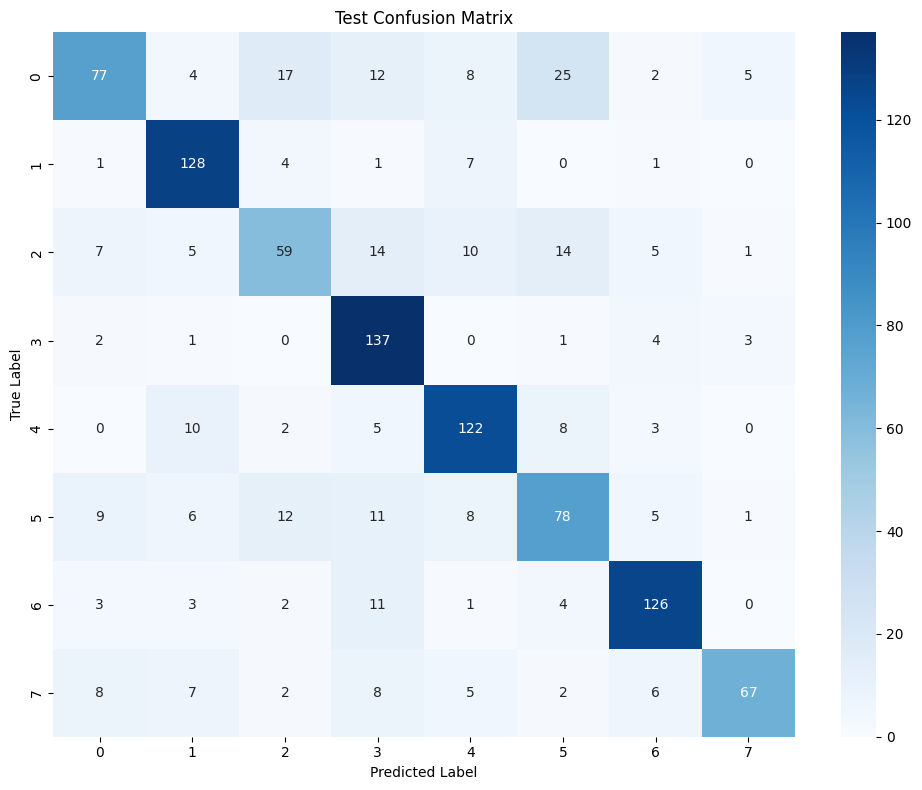

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7284403443336487     │
│        test_auroc         │    0.9522894620895386     │
│          test_f1          │    0.7162656784057617     │
│         test_loss         │    0.8236463665962219     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8236463665962219,
  'test_accuracy': 0.7284403443336487,
  'test_f1': 0.7162656784057617,
  'test_auroc': 0.9522894620895386}]

In [ ]:
trainer.test(model=model2, datamodule=garbage_classification_data)

In [ ]:
torch.save(model2, "efficientnetv2-finetuned.pth")

## Comparison / Analysis

### Method 1 Results:
Accuracy: 0.7110

Macro F1 Score: 0.7066

AUROC: 0.9530

### Method 2 Results:
Accuracy: 0.7284

Macro F1 Score: 0.7163

AUROC: 0.9523

## Conclusion

Method 2 has slightly better test accuracy and F1 score, but not much of an improvement is seen.